# Orlando Crime Classification Notebook

### 1. Importing Libraries

In [1]:
import pandas as pd # for data manipulation
import numpy as np # for arithmetic operations
import math
import matplotlib.pyplot as plt # for plotting
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier # for machine learning

### 2. Load Data

In [2]:
# reading the csv file

df = pd.read_csv('./OPD_Crimes.csv')

In [3]:
# displaying first 5 rows

df.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2009-00000022,1/1/2009 0:12,6000 Block of BUFORD ST,Residence/Single,Assault,Aggravated assault,Committed,Arrest,Mapped,"(28.50643746, -81.46509414)"
1,2009-00000090,1/1/2009 0:54,6000 Block of UNIVERSAL BV,Bar/Nightclub,Assault,Simple assault,Committed,Arrest,Mapped,"(28.47343236, -81.46410979)"
2,2009-00000114,1/1/2009 1:06,400 Block of N ORANGE BLOSSOM TL,Bar/Nightclub,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"(28.5483789, -81.39736127)"
3,2009-00000149,1/1/2009 1:29,4100 Block of S SEMORAN BV,Apartment/Condo,Robbery,Robbery,Committed,Closed,Mapped,"(28.50251214, -81.3102498)"
4,2009-00000181,1/1/2009 1:48,1 Block of W CHURCH ST,Highway/Roadway/Sidewalk,Assault,Simple assault,Committed,Arrest,Mapped,"(28.54032149, -81.37988988)"


### 3. Data Cleaning

In [4]:
# checking for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160947 entries, 0 to 160946
Data columns (total 10 columns):
Case Number                   160947 non-null object
Case Date Time                160947 non-null object
Case Location                 160947 non-null object
Case Offense Location Type    160947 non-null object
Case Offense Category         160947 non-null object
Case Offense Type             160947 non-null object
Case Offense Charge Type      160947 non-null object
Case Disposition              160947 non-null object
Status                        160947 non-null object
Location                      158460 non-null object
dtypes: object(10)
memory usage: 6.1+ MB


In [5]:
# removing rows with null values

df = df[df['Location'].notnull()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158460 entries, 0 to 160946
Data columns (total 10 columns):
Case Number                   158460 non-null object
Case Date Time                158460 non-null object
Case Location                 158460 non-null object
Case Offense Location Type    158460 non-null object
Case Offense Category         158460 non-null object
Case Offense Type             158460 non-null object
Case Offense Charge Type      158460 non-null object
Case Disposition              158460 non-null object
Status                        158460 non-null object
Location                      158460 non-null object
dtypes: object(10)
memory usage: 7.3+ MB


In [7]:
# separating latitude and longitude from Location 

df['Location'] = df['Location'].apply(lambda x:str(x).replace(',',''))
df['Location'] = df['Location'].apply(lambda x:str(x).replace('(',''))
df['Location'] = df['Location'].apply(lambda x:str(x).replace(')',''))

df['Lat'], df['Long'] = zip(*(location.split() for location in df['Location']))
df[['Lat','Long']] = df[['Lat', 'Long']].astype(float)

In [8]:
# separating time and date details from Case Date Time

df['Date'] = df['Case Date Time'].apply(lambda x:x.split()[0])
df['Time'] = df['Case Date Time'].apply(lambda x:(x.split()[1]).split(':')[0])
df['Time'] = df['Time'].astype(int)
df['Month'], df['Day'], df['Year'] = zip(*(date.split('/') for date in df['Date']))

In [9]:
df.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Lat,Long,Date,Time,Month,Day,Year
0,2009-00000022,1/1/2009 0:12,6000 Block of BUFORD ST,Residence/Single,Assault,Aggravated assault,Committed,Arrest,Mapped,28.50643746 -81.46509414,28.506437,-81.465094,1/1/2009,0,1,1,2009
1,2009-00000090,1/1/2009 0:54,6000 Block of UNIVERSAL BV,Bar/Nightclub,Assault,Simple assault,Committed,Arrest,Mapped,28.47343236 -81.46410979,28.473432,-81.464110,1/1/2009,0,1,1,2009
2,2009-00000114,1/1/2009 1:06,400 Block of N ORANGE BLOSSOM TL,Bar/Nightclub,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,28.5483789 -81.39736127,28.548379,-81.397361,1/1/2009,1,1,1,2009
3,2009-00000149,1/1/2009 1:29,4100 Block of S SEMORAN BV,Apartment/Condo,Robbery,Robbery,Committed,Closed,Mapped,28.50251214 -81.3102498,28.502512,-81.310250,1/1/2009,1,1,1,2009
4,2009-00000181,1/1/2009 1:48,1 Block of W CHURCH ST,Highway/Roadway/Sidewalk,Assault,Simple assault,Committed,Arrest,Mapped,28.54032149 -81.37988988,28.540321,-81.379890,1/1/2009,1,1,1,2009


### 4. Machine Learning Model

In [10]:
# logloss function

def ll(act, pred):
    return (-(~(act == pred)).astype(int) * math.log(1e-15)).sum() / len(act)

In [11]:
# spliting training and testing data

msk = np.random.rand(len(df)) < 0.7
knn_train = df[msk]
knn_test = df[~msk]
n = len(knn_test)

In [12]:
x = knn_train[['Lat','Long']]
y = knn_train['Case Offense Category'].astype('category')
actual = knn_test['Case Offense Category'].astype('category')

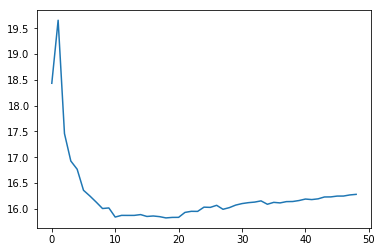

In [13]:
# finding optimal number of neighbours

logloss = []
for i in range(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x, y)
    outcome = knn.predict(knn_train[['Lat','Long']])
    logloss.append(ll(y, outcome))

plt.plot(logloss)
#plt.savefig('n_neighbors_vs_logloss.png')
plt.show()

In [14]:
# applying k-nearest neighbours to predict on test data

knnTest = KNeighborsClassifier(n_neighbors=18)
knnTest.fit(x,y)
pred = knnTest.predict(knn_test[['Lat','Long']])

In [15]:
crime = pd.DataFrame()
for category in y.cat.categories:
    crime[category] = np.where(pred == category, 1, 0) 

In [16]:
crime.head(10)

,Arson,Assault,Bribery,Burglary,Embezzlement,Fraud,Homicide,Kidnapping,Narcotics,Robbery,Theft,Vehicle Theft
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,1,0
